# Question duplicates

### Overview

- Imported the Data
- Splitted the data into train and test set
- Converted the questions(data) into tensors
- Created the validation set
- Created a function for data generator
- Created a function to implement Siamese model
- Computed Triplet Loss with Hard Negative Mining
- Trained the Siamese model and checked the performance on validation set 
- Evaluated the the model on test data and achieved an accuracy of 71.5%
- Created a predict function which helped in Testing with our own questions

## Importing the Data

We will be using the Quora question answer dataset to build a model that could identify similar questions. This is a useful task because we don't want to have several versions of the same question posted.

In [1]:
import os
import nltk
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
import pandas as pd
import random as rnd

# set random seeds
trax.supervised.trainer_lib.init_random_number_generators(34)
rnd.seed(34)

INFO:tensorflow:tokens_length=568 inputs_length=512 targets_length=114 noise_density=0.15 mean_noise_span_length=3.0 


/Users/amanprasad/opt/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
data = pd.read_csv("questions.csv")
N=len(data)
print('Number of question pairs: ', N)
data.head()

Number of question pairs:  404351


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We first split the data into a train and test set. The test set will be used later to evaluate our model.

In [3]:
N_train = 300000
N_test  = 10*1024
data_train = data[:N_train]
data_test  = data[N_train:N_train+N_test]
print("Train set:", len(data_train), "Test set:", len(data_test))
del(data) # remove to free memory

Train set: 300000 Test set: 10240


We build two batches as input for the Siamese network and we assume that question $q1_i$ (question $i$ in the first batch) is a duplicate of $q2_i$ (question $i$ in the second batch), but all other questions in the second batch are not duplicates of $q1_i$.  
The test set uses the original pairs of questions and the status describing if the questions are duplicates.

In [4]:
td_index = (data_train['is_duplicate'] == 1).to_numpy()
td_index = [i for i, x in enumerate(td_index) if x] 
print('number of duplicate questions: ', len(td_index))
print('indexes of first ten duplicate questions:', td_index[:10])

number of duplicate questions:  111486
indexes of first ten duplicate questions: [5, 7, 11, 12, 13, 15, 16, 18, 20, 29]


In [5]:
print(data_train['question1'][5])  #  Example of question duplicates (first one in data)
print(data_train['question2'][5])
print('is_duplicate: ', data_train['is_duplicate'][5])

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
is_duplicate:  1


In [6]:
Q1_train_words = np.array(data_train['question1'][td_index])
Q2_train_words = np.array(data_train['question2'][td_index])

Q1_test_words = np.array(data_test['question1'])
Q2_test_words = np.array(data_test['question2'])
y_test  = np.array(data_test['is_duplicate'])

Above, we have took the duplicated questions for training our model.<br>
We did so on purpose, because the data generator will produce batches $([q1_1, q1_2, q1_3, ...]$, $[q2_1, q2_2,q2_3, ...])$  where $q1_i$ and $q2_k$ are duplicate if and only if $i = k$.<br>
Let's print to see what your data looks like.

In [7]:
print('TRAINING QUESTIONS:\n')
print('Question 1: ', Q1_train_words[0])
print('Question 2: ', Q2_train_words[0], '\n')
print('Question 1: ', Q1_train_words[5])
print('Question 2: ', Q2_train_words[5], '\n')

print('TESTING QUESTIONS:\n')
print('Question 1: ', Q1_test_words[0])
print('Question 2: ', Q2_test_words[0], '\n')
print('is_duplicate =', y_test[0], '\n')

TRAINING QUESTIONS:

Question 1:  Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Question 2:  I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me? 

Question 1:  What would a Trump presidency mean for current international master’s students on an F1 visa?
Question 2:  How will a Trump presidency affect the students presently in US or planning to study in US? 

TESTING QUESTIONS:

Question 1:  How do I prepare for interviews for cse?
Question 2:  What is the best way to prepare for cse? 

is_duplicate = 0 



We will now encode each word of the selected duplicate pairs with an index. <br> Given a question, we can then just encode it as a list of numbers.  

First we tokenize the questions using `nltk.word_tokenize`. <br>
We need a python default dictionary which later, during inference, assigns the values $0$ to all Out Of Vocabulary (OOV) words.<br>
Then we encode each word of the selected duplicate pairs with an index. Given a question, we can then just encode it as a list of numbers. 

In [8]:
#create arrays
Q1_train = np.empty_like(Q1_train_words)
Q2_train = np.empty_like(Q2_train_words)

Q1_test = np.empty_like(Q1_test_words)
Q2_test = np.empty_like(Q2_test_words)

In [9]:
# Building the vocabulary with the train set         (this might take a minute)
from collections import defaultdict

vocab = defaultdict(lambda: 0)
vocab['<PAD>'] = 1

for idx in range(len(Q1_train_words)):
    Q1_train[idx] = nltk.word_tokenize(Q1_train_words[idx])
    Q2_train[idx] = nltk.word_tokenize(Q2_train_words[idx])
    q = Q1_train[idx] + Q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('The length of the vocabulary is: ', len(vocab))

The length of the vocabulary is:  36306


In [10]:
print(vocab['<PAD>'])
print(vocab['Astrology'])
print(vocab['Astronomy'])  #not in vocabulary, returns 0

1
2
0


In [11]:
for idx in range(len(Q1_test_words)): 
    Q1_test[idx] = nltk.word_tokenize(Q1_test_words[idx])
    Q2_test[idx] = nltk.word_tokenize(Q2_test_words[idx])

In [12]:
print('Train set has reduced to: ', len(Q1_train) ) 
print('Test set length: ', len(Q1_test) ) 

Train set has reduced to:  111486
Test set length:  10240


## Converting a question to a tensor

We will now convert every question to a tensor, or an array of numbers, using our vocabulary built above.

In [13]:
# Converting questions to array of integers
for i in range(len(Q1_train)):
    Q1_train[i] = [vocab[word] for word in Q1_train[i]]
    Q2_train[i] = [vocab[word] for word in Q2_train[i]]

        
for i in range(len(Q1_test)):
    Q1_test[i] = [vocab[word] for word in Q1_test[i]]
    Q2_test[i] = [vocab[word] for word in Q2_test[i]]

In [14]:
print('first question in the train set:\n')
print(Q1_train_words[0], '\n') 
print('encoded version:')
print(Q1_train[0],'\n')

print('first question in the test set:\n')
print(Q1_test_words[0], '\n')
print('encoded version:')
print(Q1_test[0]) 

first question in the train set:

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? 

encoded version:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] 

first question in the test set:

How do I prepare for interviews for cse? 

encoded version:
[32, 38, 4, 107, 65, 1015, 65, 11514, 21]


We will now split our train set into a training/validation set so that we can use it to train and evaluate our Siamese model.

In [15]:
# Splitting the data
cut_off = int(len(Q1_train)*.8)
train_Q1, train_Q2 = Q1_train[:cut_off], Q2_train[:cut_off]
val_Q1, val_Q2 = Q1_train[cut_off: ], Q2_train[cut_off:]
print('Number of duplicate questions: ', len(Q1_train))
print("The length of the training set is:  ", len(train_Q1))
print("The length of the validation set is: ", len(val_Q1))

Number of duplicate questions:  111486
The length of the training set is:   89188
The length of the validation set is:  22298


## Data Generator

We will use batches when training our data sets. If we were to use stochastic gradient descent with one example at a time, it will take us forever to build a model. In this example, we show us how we can build a data generator that takes in $Q1$ and $Q2$ and returns a batch of size `batch_size`  in the following format $([q1_1, q1_2, q1_3, ...]$, $[q2_1, q2_2,q2_3, ...])$. The tuple consists of two arrays and each array has `batch_size` questions. Again, $q1_i$ and $q2_i$ are duplicates, but they are not duplicates with any other elements in the batch. 

In [16]:
def data_generator(Q1, Q2, batch_size, pad=1, shuffle=True):
    """Generator function that yields batches of data

    Args:
        Q1 (list): List of transformed (to tensor) questions.
        Q2 (list): List of transformed (to tensor) questions.
        batch_size (int): Number of elements per batch.
        pad (int, optional): Pad character from the vocab. Defaults to 1.
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Yields:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to your model [q1a, q2a, q3a, ...] i.e. (q1a,q1b) are duplicates
              input2: targets to your model [q1b, q2b,q3b, ...] i.e. (q1a,q2i) i!=a are not duplicates
    """

    input1 = []
    input2 = []
    idx = 0
    len_q = len(Q1)
    question_indexes = [*range(len_q)]
    
    if shuffle:
        rnd.shuffle(question_indexes)
    
    while True:
        if idx >= len_q:
            # if idx is greater than or equal to len_q, set idx accordingly 
            idx = 0
            # shuffle to get random batches if shuffle is set to True
            if shuffle:
                rnd.shuffle(question_indexes)
        
        # get questions at the position in Q1 and Q2
        q1 = Q1[question_indexes[idx]]
        q2 = Q2[question_indexes[idx]]
        
        # increment idx by 1
        idx += 1
        # append q1
        input1.append(q1)
        # append q2
        input2.append(q2)
        if len(input1) == batch_size:
            # determine max_len as the longest question in input1 & input 2
            # take max of input1 & input2 and then max out of the two of them.
            max_len = max(max([len(q) for q in input1]),max([len(q) for q in input2]))
            # Ceil max_len to a power of  2  (for computation purposes) 
            max_len = 2**int(np.ceil(np.log2(max_len)))
            b1 = []
            b2 = []
            for q1, q2 in zip(input1, input2):
                # add [pad] to q1 until it reaches max_len
                q1 = q1 + [pad] * (max_len - len(q1))
                # add [pad] to q2 until it reaches max_len
                q2 = q2 + [pad] * (max_len - len(q2))
                # append q1
                b1.append(q1)
                # append q2
                b2.append(q2)
            # use b1 and b2
            yield np.array(b1), np.array(b2)

            # reset the batches
            input1, input2 = [], []

In [17]:
batch_size = 2
res1, res2 = next(data_generator(train_Q1, train_Q2, batch_size))
print("First questions  : ",'\n', res1, '\n')
print("Second questions : ",'\n', res2)

First questions  :  
 [[  30   87   78  134 2131 1980   28   78  594   21    1    1    1    1
     1    1]
 [  30   55   78 3540 1460   28   56  253   21    1    1    1    1    1
     1    1]] 

Second questions :  
 [[  30  156   78  134 2131 9510   21    1    1    1    1    1    1    1
     1    1]
 [  30  156   78 3540 1460  131   56  253   21    1    1    1    1    1
     1    1]]


## Defining the Siamese model

A Siamese network is a neural network which uses the same weights while working in tandem on two different input vectors to compute comparable output vectors. The Siamese network we are about to implement looks like this:

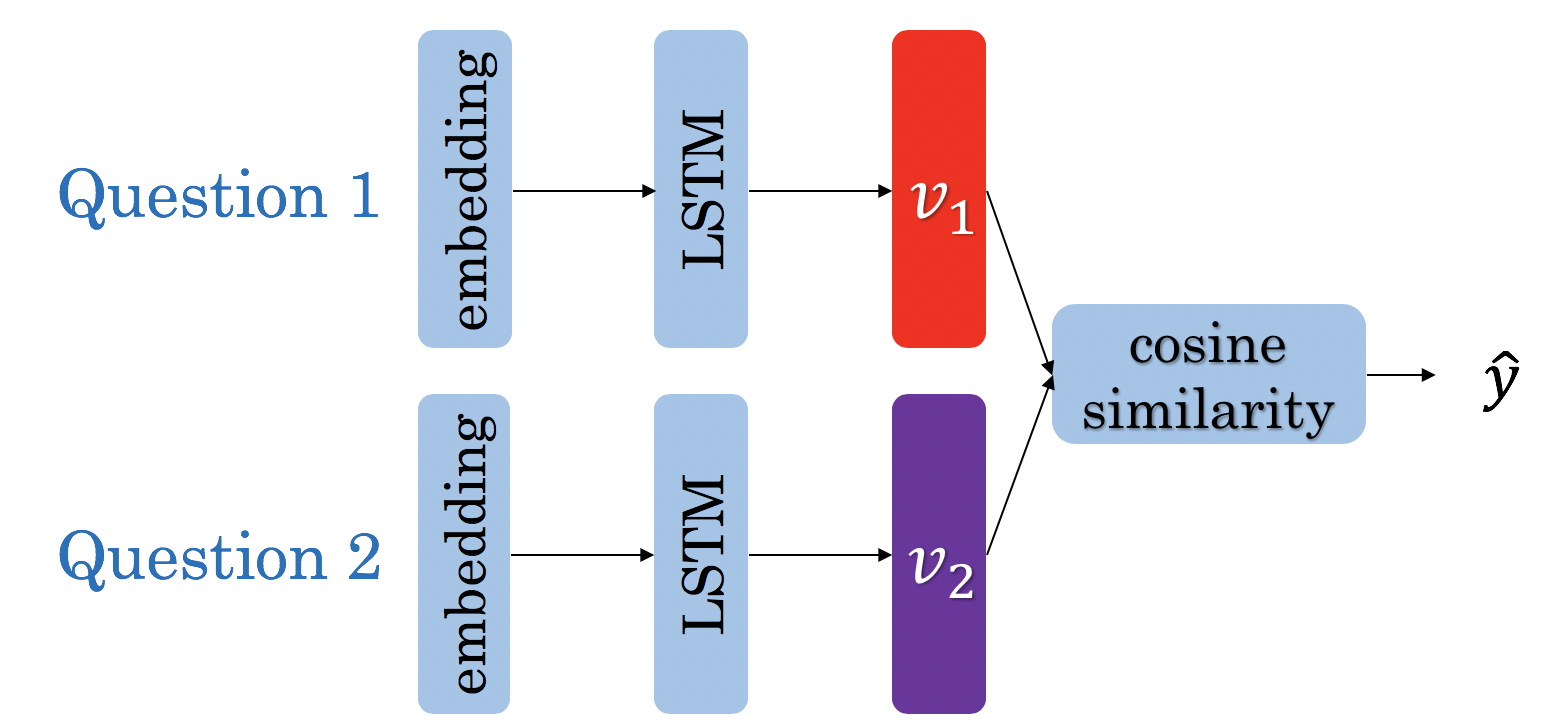

In [18]:
from IPython.display import Image
Image(filename='/Users/amanprasad/Documents/Courses_IIT_Fall_2019/NLP/Question_Duplicates/siamese.png')

We get the question embedding, run it through an LSTM layer, normalize $v_1$ and $v_2$, and finally use a triplet loss (explained below) to get the corresponding cosine similarity for each pair of questions. As usual, we will start by importing the data set. The triplet loss makes use of a baseline (anchor) input that is compared to a positive (truthy) input and a negative (falsy) input. The distance from the baseline (anchor) input to the positive (truthy) input is minimized, and the distance from the baseline (anchor) input to the negative (falsy) input is maximized. In math equations, we are trying to maximize the following.

$$\mathcal{L}(A, P, N)=\max \left(\|\mathrm{f}(A)-\mathrm{f}(P)\|^{2}-\|\mathrm{f}(A)-\mathrm{f}(N)\|^{2}+\alpha, 0\right)$$

$A$ is the anchor input, for example $q1_1$, $P$ the duplicate input, for example, $q2_1$, and $N$ the negative input (the non duplicate question), for example $q2_2$.<br>
$\alpha$ is a margin; we can think about it as a safety net, or by how much we want to push the duplicates from the non duplicates. 

In [19]:
def Siamese(vocab_size=len(vocab), d_model=128, mode='train'):
    """Returns a Siamese model.

    Args:
        vocab_size (int, optional): Length of the vocabulary. Defaults to len(vocab).
        d_model (int, optional): Depth of the model. Defaults to 128.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to 'train'.

    Returns:
        A Siamese model. 
    """

    def normalize(x):  # normalizes the vectors to have L2 norm 1
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))
    
    q_processor = tl.Serial(  # Processor will run on Q1 and Q2.
        tl.Embedding(vocab_size, d_model), # Embedding layer
        tl.LSTM(d_model), # LSTM layer
        tl.Mean(axis=1), # Mean over columns
        tl.Fn('Normalize', lambda x: normalize(x))  # Apply normalize function
    )  # Returns one vector of shape [batch_size, d_model].
    
    
    # Run on Q1 and Q2 in parallel.
    model = tl.Parallel(q_processor, q_processor)
    return model


In [20]:
model = Siamese()
print(model)

Parallel_in2_out2[
  Serial[
    Embedding_41748_128
    LSTM_128
    Mean
    Normalize
  ]
  Serial[
    Embedding_41748_128
    LSTM_128
    Mean
    Normalize
  ]
]


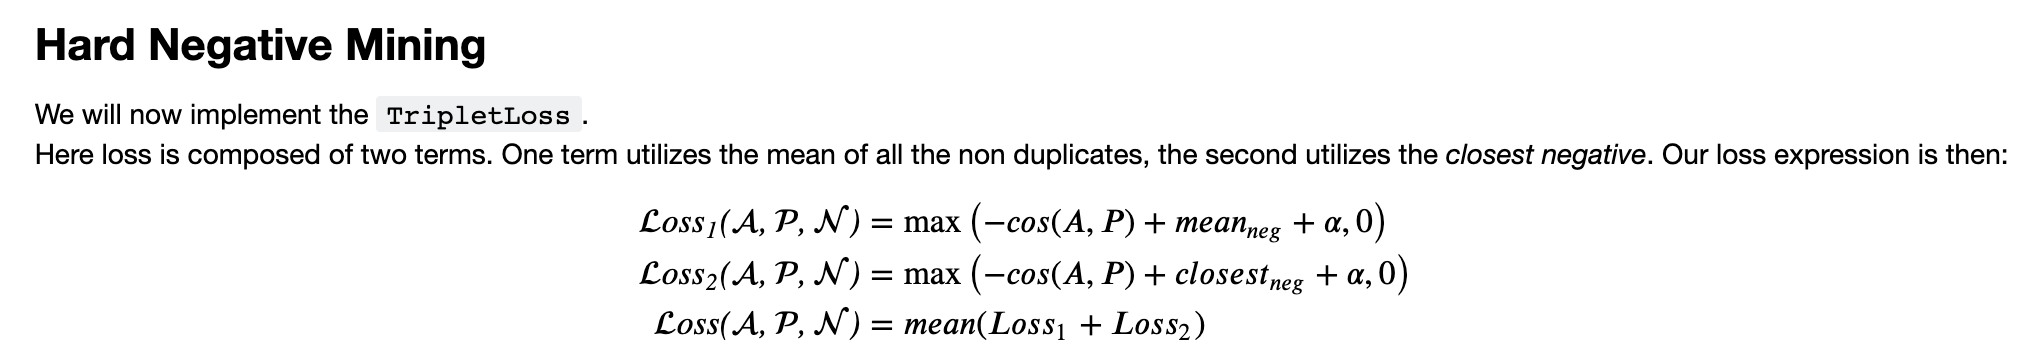

In [45]:
Image(filename='/Users/amanprasad/Documents/Courses_IIT_Fall_2019/NLP/Question_Duplicates/Hard_Mining.png')

In [21]:
def TripletLossFn(v1, v2, margin=0.25):
    """Custom Loss function.

    Args:
    v1 (numpy.ndarray): Array with dimension (batch_size, model_dimension) associated to Q1.
    v2 (numpy.ndarray): Array with dimension (batch_size, model_dimension) associated to Q2.
    margin (float, optional): Desired margin. Defaults to 0.25.

    Returns:
    Triplet Loss
    """
    
    scores = fastnp.dot(v1, v2.T)  # pairwise cosine sim
    # calculate new batch size
    batch_size = len(scores)
    # grab all postive `diagonal` entries in `scores`
    positive = fastnp.diagonal(scores)  # the positive ones (duplicates)
    # multiply identity matrix of size = batch_size with 2.0 and subtract it out of `scores`
    negative_without_positive = scores - 2.0 * fastnp.eye(batch_size)
    # take the row by row `max` of `negative_without_positive`. 
    closest_negative = negative_without_positive.max(axis=1) # [batch]
    # subtract identity matrix out of 1.0 and do element-wise multiplication with `scores`
    negative_zero_on_duplicate = scores * (1.0 - fastnp.eye(batch_size))
    # take sum on `negative_zero_on_duplicate` for `axis=1` and divide it by `(batch_size - 1)` 
    mean_negative = np.sum(negative_zero_on_duplicate, axis=1) / (batch_size-1)
    # compute max among 0.0 and `A`
    # A = subtract `positive` from `margin` and add `closest_negative` 
    triplet_loss1 = fastnp.maximum(0.0, margin - positive + closest_negative)
    # compute max among 0.0 and `B`
    # B = subtract `positive` from `margin` and add `mean_negative`
    triplet_loss2 = fastnp.maximum(0.0, margin - positive + mean_negative)
    # add the two losses together and take the mean of it
    triplet_loss = fastnp.mean(triplet_loss1 + triplet_loss2)


    return triplet_loss

In [22]:
v1 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
v2 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
TripletLossFn(v2,v1)
print("Triplet Loss:", TripletLossFn(v2,v1))

Triplet Loss: 0.5


To make a layer out of a function with no trainable variables

In [23]:
from functools import partial
def TripletLoss(margin=0.25):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return tl.Fn('TripletLoss', triplet_loss_fn)

## Training

Now we are going to train our model. As usual, we have to define the cost function and the optimizer. We also have to feed in the built model. We will define the inputs using the data generator we built above.

In [24]:
batch_size = 256
train_generator = data_generator(train_Q1, train_Q2, batch_size, vocab['<PAD>'])
val_generator = data_generator(val_Q1, val_Q2, batch_size, vocab['<PAD>'])
print('train_Q1.shape ', train_Q1.shape)
print('val_Q1.shape   ', val_Q1.shape)

train_Q1.shape  (89188,)
val_Q1.shape    (22298,)


In [31]:
lr_schedule = trax.lr.warmup_and_rsqrt_decay(400, 0.01)

def train_model(Siamese, TripletLoss, lr_schedule, train_generator=train_generator, val_generator=val_generator, output_dir='model/'):
    """Training the Siamese Model

    Args:
        Siamese (function): Function that returns the Siamese model.
        TripletLoss (function): Function that defines the TripletLoss loss function.
        lr_schedule (function): Trax multifactor schedule function.
        train_generator (generator, optional): Training generator. Defaults to train_generator.
        val_generator (generator, optional): Validation generator. Defaults to val_generator.
        output_dir (str, optional): Path to save model to. Defaults to 'model/'.

    Returns:
        Training loop for the model.
    """
    output_dir = os.path.expanduser(output_dir)


    train_task = training.TrainTask(
        labeled_data=train_generator,         
        loss_layer=TripletLoss(),             
        optimizer=trax.optimizers.Adam(0.01), 
        lr_schedule=lr_schedule,              
    )

    eval_task = training.EvalTask(
        labeled_data=val_generator,       
        metrics=[TripletLoss()],          
    )
    
    training_loop = training.Loop(Siamese(),
                                  train_task,
                                  eval_task=eval_task,
                                  output_dir=output_dir)

    return training_loop

In [32]:
train_steps = 500
training_loop = train_model(Siamese, TripletLoss, lr_schedule)
training_loop.run(train_steps)

Step      1: train TripletLoss |  0.49967423
Step      1: eval  TripletLoss |  0.49816972
Step    100: train TripletLoss |  0.41778752
Step    100: eval  TripletLoss |  0.26311782
Step    200: train TripletLoss |  0.19573063
Step    200: eval  TripletLoss |  0.13491930
Step    300: train TripletLoss |  0.12688631
Step    300: eval  TripletLoss |  0.12498353
Step    400: train TripletLoss |  0.10500374
Step    400: eval  TripletLoss |  0.10024616
Step    500: train TripletLoss |  0.09086557
Step    500: eval  TripletLoss |  0.07936069


## Evaluation  

In [33]:
model=training_loop.eval_model

In [34]:
def classify(test_Q1, test_Q2, y, threshold, model, vocab, data_generator=data_generator, batch_size=64):
    """Function to test the accuracy of the model.

    Args:
        test_Q1 (numpy.ndarray): Array of Q1 questions.
        test_Q2 (numpy.ndarray): Array of Q2 questions.
        y (numpy.ndarray): Array of actual target.
        threshold (float): Desired threshold.
        model (trax.layers.combinators.Parallel): The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        batch_size (int, optional): Size of the batches. Defaults to 64.

    Returns:
        float: Accuracy of the model.
    """
    accuracy = 0
    
    for i in range(0, len(test_Q1), batch_size):
        q1, q2 = next(data_generator(
            test_Q1[i:i + batch_size], test_Q2[i:i + batch_size], batch_size, vocab['<PAD>'], shuffle=False))
        
        y_test = y[i:i + batch_size]
        # Call the model
        v1, v2 = model((q1, q2))

        for j in range(batch_size):
            # take dot product to compute cos similarity of each pair of entries, v1[j], v2[j]
            d = np.dot(v1[j], v2[j].T)
            # is d greater than the threshold?
            res = d > threshold
            # increment accurancy if y_test is equal `res`
            accuracy += (y_test[j] == res)
    
    accuracy = accuracy / len(test_Q1)
    
    return accuracy

In [35]:
accuracy = classify(Q1_test,Q2_test, y_test, 0.7, model, vocab, batch_size = 512) 
print("Accuracy", accuracy)

Accuracy 0.71484375


## Testing with your own questions

In [36]:
def predict(question1, question2, threshold, model, vocab, data_generator=data_generator, verbose=False):
    """Function for predicting if two questions are duplicates.

    Args:
        question1 (str): First question.
        question2 (str): Second question.
        threshold (float): Desired threshold.
        model (trax.layers.combinators.Parallel): The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        verbose (bool, optional): If the results should be printed out. Defaults to False.

    Returns:
        bool: True if the questions are duplicates, False otherwise.
    """
    # use `nltk` word tokenize function to tokenize
    q1 = nltk.word_tokenize(question1)  # tokenize
    q2 = nltk.word_tokenize(question2)  # tokenize
    Q1, Q2 = [], []
    for word in q1:  # encode q1
        # increment by checking the 'word' index in `vocab`
        Q1 += [vocab[word]]
    for word in q2:  # encode q2
        # increment by checking the 'word' index in `vocab`
        Q2 += [vocab[word]]
        
    Q1, Q2 = next(data_generator([Q1], [Q2], 1, vocab['<PAD>']))
    # Call the model
    v1, v2 = model((Q1, Q2))
    # take dot product to compute cos similarity of each pair of entries, v1, v2
    d = np.dot(v1[0], v2[0].T)
    # is d greater than the threshold?
    res = d > threshold
    
    
    if(verbose):
        print("Q1  = ", Q1, "\nQ2  = ", Q2)
        print("d   = ", d)
        print("res = ", res)

    return res

In [37]:
question1 = "When will I see you?"
question2 = "When can I see you again?"
# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, vocab, verbose = True)

Q1  =  [[585  76   4  46  53  21   1   1]] 
Q2  =  [[ 585   33    4   46   53 7282   21    1]]
d   =  0.7866231
res =  True


True

In [38]:
question1 = "Do they enjoy eating the dessert?"
question2 = "Do they like hiking in the desert?"
# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, vocab, verbose=True)

Q1  =  [[  443  1145  3158  1169    78 29039    21     1]] 
Q2  =  [[  443  1145    60 15312    28    78  7433    21]]
d   =  0.61577374
res =  False


False